# Fake News Detection

**Author**: Marcelo Scatena
***
March 2022

<img src='./images/The_fin_de_siecle_newspaper_proprietor.jpg' width=1000 align='left'/>

[Image Source](https://en.wikipedia.org/wiki/Fake_news#/media/File:The_fin_de_si%C3%A8cle_newspaper_proprietor_(cropped).jpg)

# Table of Contents
* [Overview](#Overview)
* [Business Problem](#Business_Problem)
* [Data Understanding](#Data_Understanding)
* [I. Data Exploration](#Data_Exploration)
    * [Text Preprocessing](#Text_Preprocessing)
    * [Word Clouds](#Wordclouds)
    * [Word Vectorization](#Vectorization)
* [II. Data Modeling](#Data_Modeling)    
    * [Classification Models](#Classification)
    * [Neural Network](#Neural_Network)
    * [Clustering](#Clustering)
    * [LDA](#LDA)
* [III. Final Model](#Final_Model)
* [IV. Results](#Results)
* [V. Recommendations](#Recommendations)
* [Next Steps](#Next_Steps)
* [Contact](#Contact)

# Overview <a class="anchor" id="Overview"></a>
Fake news has become increasingly more common in the past decades. It's effectiveness cannot be misjudged, as it can aid people in not taking responsability, in winning arguments or, in a bigger scale, elections. In 2016 hundreds of teenagers in Europe were hired to write false stories about the US election. Their stories would be retweeted or shared on social media or direct message hundreds and thousands of times, reaching millions of people. It's hard to quantify how much those stories could influence an outcome, but nearing the end of the election, fake news had a higher engagement count than mainstream news.<br />
Stories like this are not only recent though. One can easily look at las century history when some say [Hitler Pioneered 'Fake News'](https://www.nytimes.com/2019/10/16/opinion/hitler-speech-1919.html), but this has happened for milenia, with counts in 1274 bce, where Ramses's II accounts of [The Battle of Kadesh](https://www.ingeniahistory.com/post/the-battle-of-kadesh) have been gravely misconstruded.

# Business Problem <a class="anchor" id="Business_problem"></a>
Detecting fake news is a very challenging task. If the platform where it is being broadcasted can be biased, and one simply can't have access to the source material, how can you attest to it's truthness? We also have to take into consideration that out of those fake news, some of them could have been written as parody, some completely fabricated, some manipulated or making false connections.<br />
To better understand how to assess if a news is fake or true, I'll be using Natural Language Processing.

# Data Understanding <a class="anchor" id="Data_Understanding"></a>
With the idea of trying to improve fake news classification, the LIAR dataset was created in 2017, containing 12.8 thousand manually labeled short statements from the last decade gathered from PolitiFact.com, which provides detailed analysis report and links to source document to each case. This is the most accuratly labeled dataset on the subject and became a benchmark for it.<br />
The data consists of 12.8k rows with 14 different features containing: Statement ID, Label, Statement, Speaker, Speaker's job title, State, Speaker's party affiliation, the statement credit count (from pants on fire to true), Venue or Location of statement and the Justification for the labeling. I'll explore all the metadata but will create my models using only the 'statement' and 'label' features, since I want to see if the models can be used in broader situations.<br />
[Link](https://github.com/Tariq60/LIAR-PLUS) to dataset.

# I. Data Exploration <a class="anchor" id="Data_Exploration"></a>
To start with, we load the dataset and explore its values.

In [208]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#Data Modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Data Evaluation 
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate , GridSearchCV, RandomizedSearchCV

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

# Set the same random_state
seed = 29

In [2]:
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
raw_train = pd.read_csv('data/train2.tsv', sep='\t', names=col_names)
raw_test = pd.read_csv('data/test2.tsv', sep='\t', names=col_names)
raw_val = pd.read_csv('data/val2.tsv', sep='\t', names=col_names)

In [6]:
raw_train.head()

,ID,label,statement,subject,speaker,speaker's title,state,party,barely true,false,half true,mostly true,pants on fire,context,justification
0.0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [7]:
raw_train['label'].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

In [8]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10242 entries, 0.0 to 10268.0
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   speaker's title  7343 non-null   object 
 6   state            8032 non-null   object 
 7   party            10238 non-null  object 
 8   barely true      10238 non-null  float64
 9   false            10238 non-null  float64
 10  half true        10238 non-null  float64
 11  mostly true      10238 non-null  float64
 12  pants on fire    10238 non-null  float64
 13  context          10138 non-null  object 
 14  justification    10154 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.3+ MB


In [11]:
raw_train.isna().sum()

ID                    2
label                 2
statement             2
subject               4
speaker               4
speaker's title    2899
state              2210
party                 4
barely true           4
false                 4
half true             4
mostly true           4
pants on fire         4
context             104
justification        88
dtype: int64

We can see some features with lots of missing values, but the Label and Statement features are almost full.

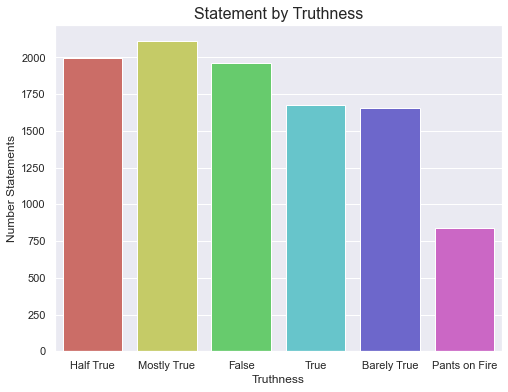

In [30]:
# Visualize the count of classes of target variable
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='label', data=raw_train, palette='hls')
ax.set_title('Statement by Truthness', fontsize=16)
ax.set_xlabel('Truthness', fontsize=12)
ax.set_xticklabels(['Half True', 'Mostly True', 'False', 'True', 'Barely True', 'Pants on Fire'])
ax.set_ylabel('Number Statements', fontsize=12);

Apart from 'Pants on Fire', the data seems to be fairly balanced.

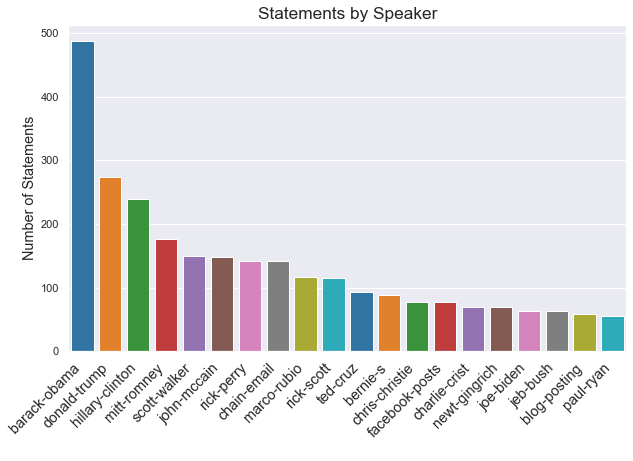

In [45]:
#visualize the counts of statements by speaker

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=raw_train, 
    x="speaker", order=raw_train["speaker"].value_counts()[:20].index,
    palette='tab10')

ax.set_title('Statements by Speaker', fontsize='x-large')
ax.set_xlabel(' ')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
ax.set_ylabel('Number of Statements',fontsize='large');

Barack Obaba has the highest number of statements in the dataset, followed by Donald Trump and Hillary Clinton.

<AxesSubplot:xlabel='label', ylabel='count'>

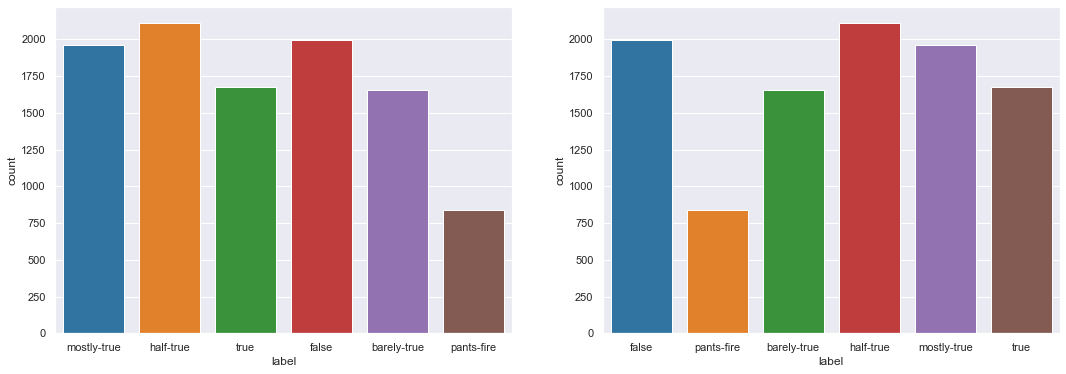

In [60]:
#visualize the counts of true statements by speaker Obama / Trump

fig, axes = plt.subplots(ncols=2, figsize=(18,6))

sns.countplot(
    data=raw_train, 
    x="label", order=raw_train[raw_train['speaker']=='barack-obama']['label'].value_counts().index,
    palette='tab10', ax=axes[0])

sns.countplot(
    data=raw_train, 
    x="label", order=raw_train[raw_train['speaker']=='donald-trump']['label'].value_counts().index,
    palette='tab10', ax=axes[1])


# ax[0].set_title('True Statements by Speaker', fontsize='x-large')
# ax[0].set_xlabel(' ')
# ax[0].set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
# ax[0].set_ylabel('Number of Statements',fontsize='large');

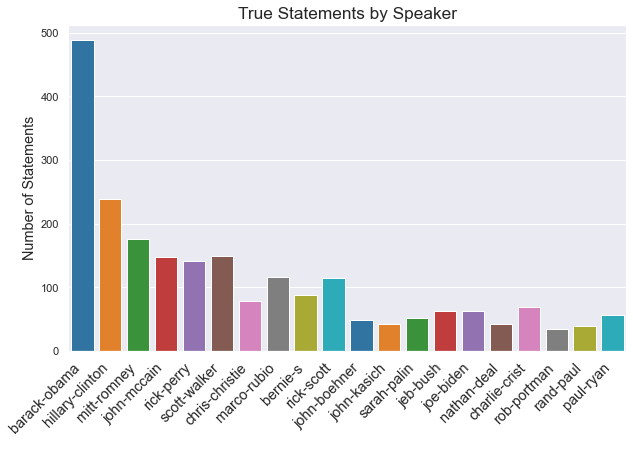

In [47]:
#visualize the counts of true statements by speaker

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=raw_train, 
    x="speaker", order=raw_train["speaker"][raw_train['label']=='true'].value_counts()[:20].index,
    palette='tab10')

ax.set_title('True Statements by Speaker', fontsize='x-large')
ax.set_xlabel(' ')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
ax.set_ylabel('Number of Statements',fontsize='large');

In [54]:
raw_train[raw_train['speaker']=='barack-obama']['label'].value_counts()

mostly-true    130
half-true      124
true           103
false           67
barely-true     56
pants-fire       8
Name: label, dtype: int64

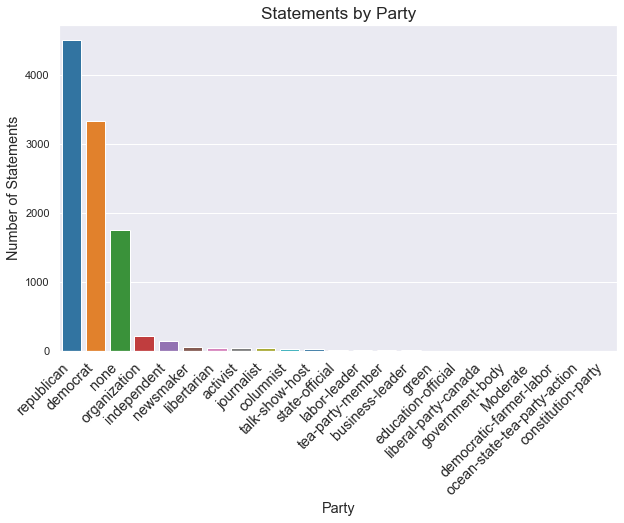

In [21]:
#visualize the counts of statements by party

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=raw_train, 
    x="party", order=raw_train["party"].value_counts().index,
    palette='tab10')

ax.set_title('Statements by Party', fontsize='x-large')
ax.set_xlabel('Party',fontsize='large')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
ax.set_ylabel('Number of Statements',fontsize='large');

There are many parties or professions that the statement orator could belong. The vast majority though are Republicans, Democrats or have no political association.

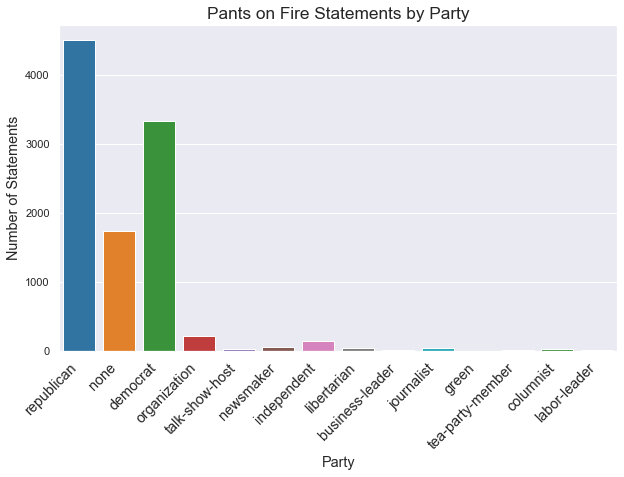

In [22]:
#visualize the counts of statements by party

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=raw_train, 
    x="party", order=raw_train['party'][raw_train['label']=='pants-fire'].value_counts().index,
    palette='tab10')

ax.set_title('Pants on Fire Statements by Party', fontsize='x-large')
ax.set_xlabel('Party',fontsize='large')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
ax.set_ylabel('Number of Statements',fontsize='large');

Here we see Republicans have the majority of the Pants on Fire statements, but they also have the majority of statements overall, so this graph by itself could be misleading.

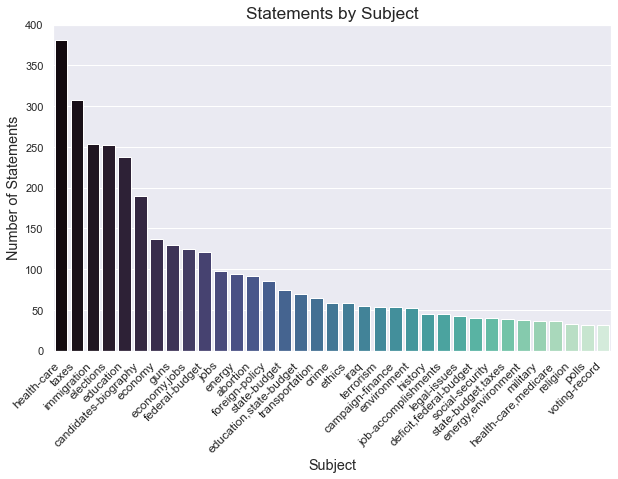

In [26]:
#visualize the counts of statements by Subject

fig, ax = plt.subplots(figsize=(10,6))

top_35_subjects = raw_train['subject'].value_counts()[:35].index.tolist()
ax = sns.countplot(
    data=raw_train, 
    x="subject", order=top_35_subjects,
    palette='mako')

ax.set_title('Statements by Subject', fontsize='x-large')
ax.set_xlabel('Subject',fontsize='large')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
ax.set_ylabel('Number of Statements',fontsize='large');

Health Care leads as the most talked about subject. It'll be interesting to note if we visualize this information again when performing nlp techniques.

0.0        Says the Annies List political group supports ...
1.0        When did the decline of coal start? It started...
2.0        Hillary Clinton agrees with John McCain "by vo...
3.0        Health care reform legislation is likely to ma...
4.0        The economic turnaround started at the end of ...
                                 ...                        
10264.0    There are a larger number of shark attacks in ...
10265.0    Democrats have now become the party of the [At...
10266.0    Says an alternative to Social Security that op...
10267.0    On lifting the U.S. Cuban embargo and allowing...
10268.0    The Department of Veterans Affairs has a manua...
Name: statement, Length: 10242, dtype: object

In [280]:
# Create new column measuring the length of statements
raw_train['words'] = raw_train['statement'].apply(lambda x: len(x.split() if type(x)==str else ' '))

In [ ]:
raw_train_copy = raw_train.copy()
raw_train_copy = raw_train_copy.fillna(' ')
raw_train_copy = raw_train_copy.reset_index(drop=True)
raw_train_copy = raw_train_copy[raw_train_copy['words']<60]
def label(df):
    df['label'] = df['label'].map({'true': 0,
                                     'mostly-true': 0,
                                     'half-true': 0,
                                     'false': 1,
                                     'barely-true': 1,
                                     'pants-fire': 1})
    return df
raw_train_copy = label(raw_train_copy)

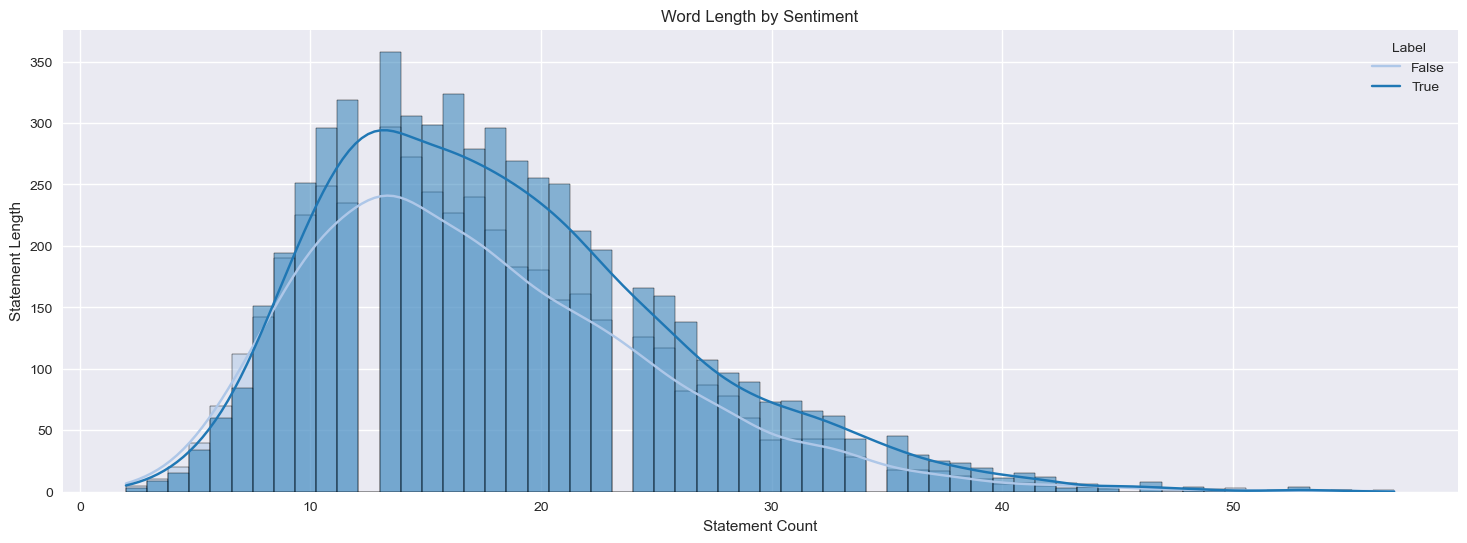

In [302]:
# Visualize the difference between length of true or false statements

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(18, 6))

sns.histplot(x='words', data=raw_train_copy, bins='auto', kde=True, hue='label', legend=True, ax=ax, palette='tab20')
ax.set_title('Word Length by Sentiment')
ax.set_xlabel('Statement Count')
ax.set_ylabel('Statement Length')
ax.legend(['False', 'True'], title='Label')

plt.show()

The distribution of false and true statements seem to follow the same pattern, with peaks occuring at above 250 words. The difference in the distribution might very easily be caused by the fact that we have more True than False statements, So I don't think this can give me any insights for classification.

## Cleaning

Building helper functions to: Drop na values, drop duplicates,

In [157]:
def drop_na(df):
    df = df.dropna(subset=['statement'], axis=0)
    return df

In [158]:
def drop_duplicated(df):
    df = df.drop_duplicates()
    return df

In [159]:
def label(df):
    df['label'] = df['label'].map({'true': 0,
                                     'mostly-true': 0,
                                     'half-true': 0,
                                     'false': 1,
                                     'barely-true': 1,
                                     'pants-fire': 1})
    return df

In [180]:
def clean(text):
    text=text.lower()
    stp=set(stopwords.words("english"))
    stp.update(['say', 'percent', 'state', 'year',
               'said', 'people', 'one'])
    placesp = re.compile('[/(){}\[\]\|@,;]')
    removech= re.compile('[^0-9a-z #+_]')
    st=WordNetLemmatizer()
    text=re.sub(placesp,' ',text)
    text=re.sub(removech,' ',text)
    text=text.split()
    text=[w for w in text if not w in stp]
    text=[st.lemmatize(w) for w in text]
    text=[w for w in text if not w in stp]
    text=" ".join(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

In [181]:
def clean_df(df):
    df['statement'] = df['statement'].apply(lambda x: clean(x))
    return df

In [162]:
def drop_features(df):
    df = df[['statement','label']]
    return df

In [163]:
def reset_index(df):
    df = df.reset_index(drop=True)
    return df

In [182]:
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('clean', FunctionTransformer(clean_df)),
    ('drop_features', FunctionTransformer(drop_features)),
    ('reset_index', FunctionTransformer(reset_index))
])

In [183]:
df_train_clean = cleaning_pipeline.fit_transform(raw_train)
df_val_clean = cleaning_pipeline.transform(raw_val)
df_test_clean = cleaning_pipeline.transform(raw_test)

In [35]:
# %store df_train_clean
# %store df_val_clean
# %store df_test_clean

Stored 'df_train_clean' (DataFrame)
Stored 'df_val_clean' (DataFrame)
Stored 'df_test_clean' (DataFrame)


In [184]:
X_train_clean = df_train_clean['statement']
y_train_clean = df_train_clean['label']
X_val_clean = df_val_clean['statement']
y_val_clean = df_val_clean['label']
X_test_clean = df_test_clean['statement']
y_test_clean = df_test_clean['label']

In [185]:
df_train_clean.head()

,statement,label
0,annies list political group support third trim...,1
1,decline coal start started natural gas took st...,0
2,hillary clinton agrees john mccain voting give...,0
3,health care reform legislation likely mandate ...,1
4,economic turnaround started end term,0


In [34]:
df_train_clean['label'].value_counts(normalize=True)

0    0.561719
1    0.438281
Name: label, dtype: float64

## Word Clouds <a class="anchor" id="Wordclouds"></a>

First one is generated using all the words in the train data

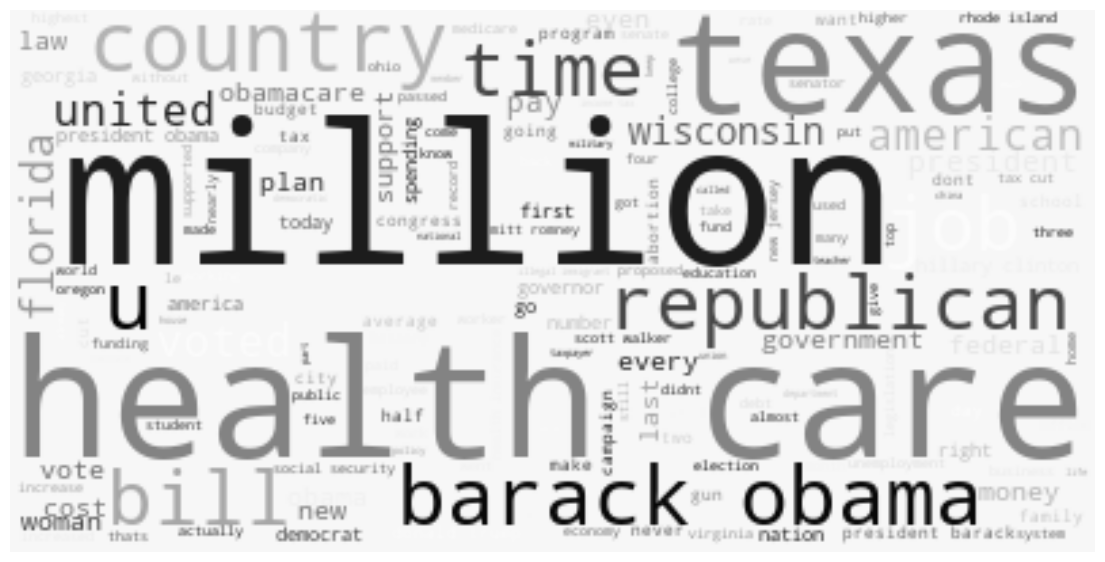

In [308]:
text = ' '.join(df_train_clean['statement'])

# Create and generate a word cloud image:
plt.figure(figsize=(14,10))
wordcloud = WordCloud(background_color='#f7f7f7', colormap='Greys_r', random_state=1).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Below we see the wordcloud for all the words in the train data that have been labeled as True.

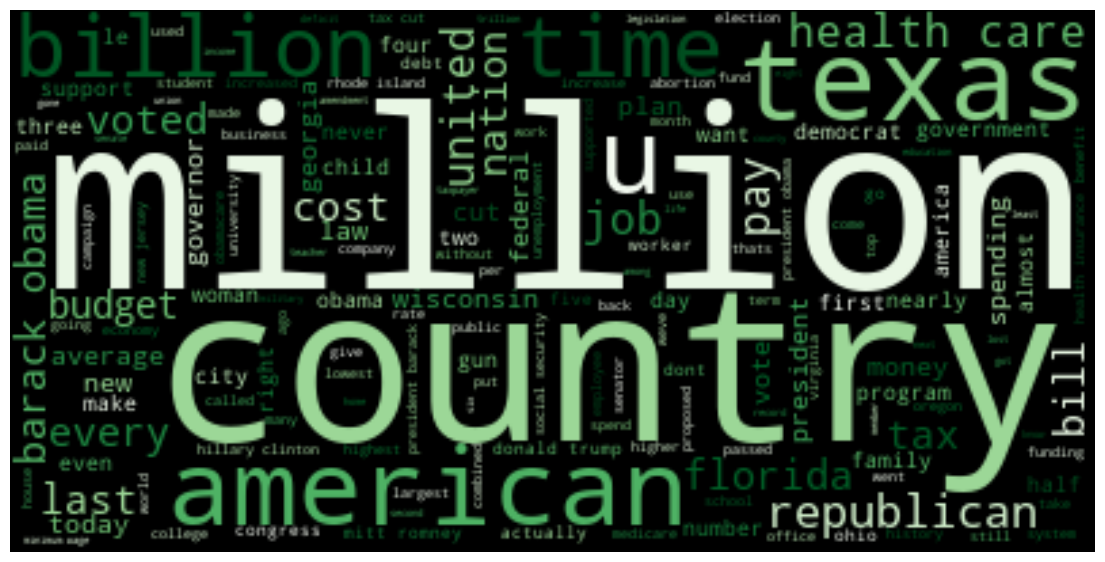

In [306]:
text = ' '.join(df_train_clean[df_train_clean['label']==0]['statement'])

# Create and generate a word cloud image:
plt.figure(figsize=(14,10))
wordcloud = WordCloud(background_color='Black', colormap='Greens', random_state=1).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Below we see the wordcloud for all the words in the train data that have been labeled as False.

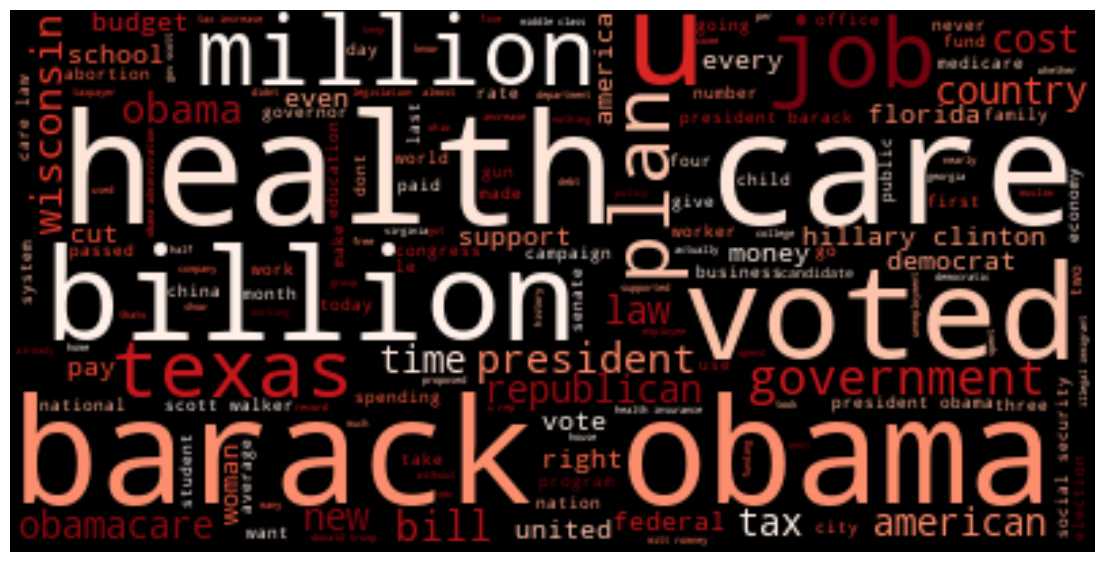

In [307]:
text = ' '.join(df_train_clean[df_train_clean['label']==1]['statement'])

# Create and generate a word cloud image:
plt.figure(figsize=(14,10))
wordcloud = WordCloud(background_color='Black', colormap='Reds', random_state=1).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

There isn't much to be gained from trying to analyse these clouds given this dataset and what it's trying to classify. I have perfomed more topic modeling in [this](link_to_nobeook) notebook.

# II. Data Modeling <a class="anchor" id="Data_Modeling"></a>

Create pipelines and helper functions to train several models at the same time.<br />
The first models will use CountVectorizer as their vectorizer.

In [225]:
mnb = Pipeline([('cv', CountVectorizer()),
               ('mnb', MultinomialNB())])

lr = Pipeline([('Vectorizer', CountVectorizer()),
               ('LogisticReg', LogisticRegression())])

dtc = Pipeline([('Vectorizer', CountVectorizer()),
               ('DecisionTree', DecisionTreeClassifier())])

rf = Pipeline([('Vectorizer', CountVectorizer()),
               ('RandomFor', RandomForestClassifier())]) 

etc = Pipeline([('Vectorizer', CountVectorizer()),
               ('ExtraTrees', ExtraTreesClassifier())]) 

gbc = Pipeline([('Vectorizer', CountVectorizer()),
               ('gradiendboosting', GradientBoostingClassifier())])

svc = Pipeline([('Vectorizer', CountVectorizer()),
                ('SupportVec', SVC())])

sgd = Pipeline([('Vectorizer', CountVectorizer()),
                ('StochGrad', SGDClassifier())])

pac = Pipeline([('Vectorizer', CountVectorizer()),
                ('PassAgress', PassiveAggressiveClassifier())])

mlp = Pipeline([('Vectorizer', CountVectorizer()),
                ('MultiLayerPerc', MLPClassifier())])

In [226]:
models1 = [('MultiNomBa', mnb),
          ('LogisticReg', lr),
          ('DecTreeClass', dtc),
          ('RandomFor', rf),
          ('ExtraTrees', etc),
          ('GradBoost', gbc),
          ('SupportVec', svc),
          ('StochGrad', sgd),
          ('PassAgress', pac),
          ('MultiLayerPerc', mlp)]

In [227]:
def fit_models(models, X, y):
    '''
    Inputs a list of (name, model), X, y
    Fits data into models
    '''
    for name, model in models:
        model.fit(X, y)
    return None

In [244]:
def print_cm_with_labels(y_true, 
                         y_pred):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    disp_labels = ['True', 'Fake']
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(disp_labels)
    return None

In [245]:
def cross_validate_models(models, X, y, cv=5, scoring='accuracy', cm=False):
    '''
    Input: Models (name, model), X, y
    Optional: cross validation (cv), scoring, confusion matric (cm)
    Output: mean of models scores
    Default cross validation = 5
    Default scoring='accuracy'
    If cm=True, print models confusion matrices. Default=False
    '''
    fit_models(models, X, y)
    results = [(name, cross_validate(model, X, y, scoring=scoring, cv=cv)) for name, model, in models]
    scores = [(result[0], result[1]['test_score'].mean()) for result in results]
    if cm==True:
        for index, model in enumerate(models):
            print(f'{model}')
            print(f'Accuracy: {results[index][1]}')
            print_cm_with_labels(y, model[1].predict(X))
    return scores

('MultiNomBa', Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())]))
Accuracy: {'fit_time': array([0.1639967 , 0.11591935]), 'score_time': array([0.07800412, 0.11352849]), 'test_score': array([0.59902344, 0.59238281])}
('LogisticReg', Pipeline(steps=[('Vectorizer', CountVectorizer()),
                ('LogisticReg', LogisticRegression())]))
Accuracy: {'fit_time': array([0.37039828, 0.28338933]), 'score_time': array([0.1532228 , 0.07814908]), 'test_score': array([0.58710938, 0.57832031])}
('DecTreeClass', Pipeline(steps=[('Vectorizer', CountVectorizer()),
                ('DecisionTree', DecisionTreeClassifier())]))
Accuracy: {'fit_time': array([1.0517242 , 1.05138612]), 'score_time': array([0.10976958, 0.12790418]), 'test_score': array([0.5640625 , 0.57246094])}
('RandomFor', Pipeline(steps=[('Vectorizer', CountVectorizer()),
                ('RandomFor', RandomForestClassifier())]))
Accuracy: {'fit_time': array([4.54556251, 4.72434187]), 'score_time': array([0.5105459

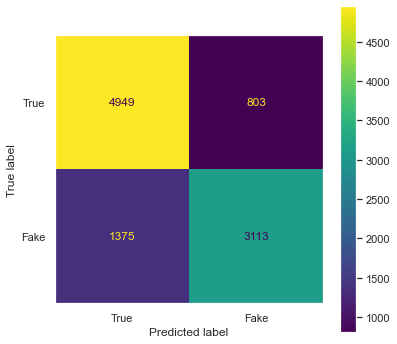

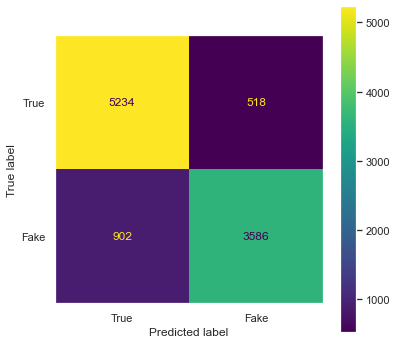

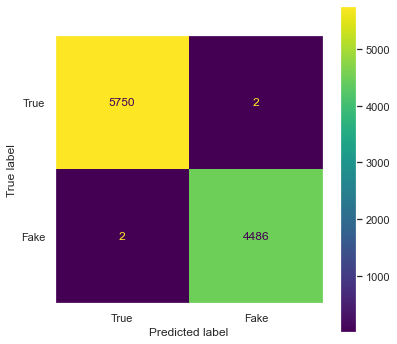

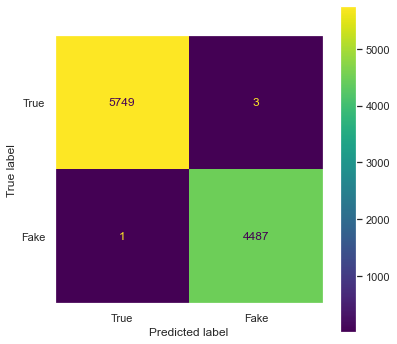

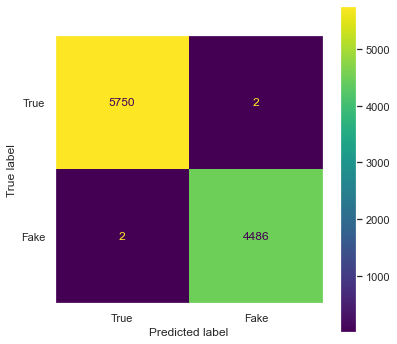

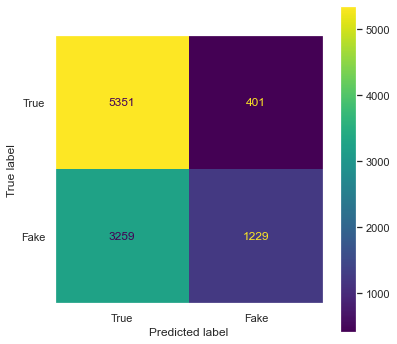

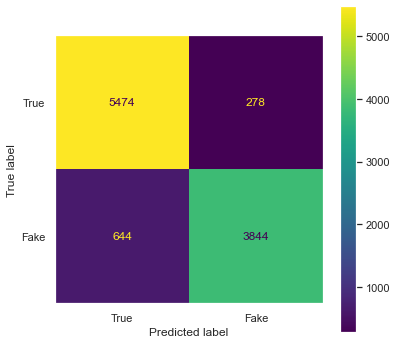

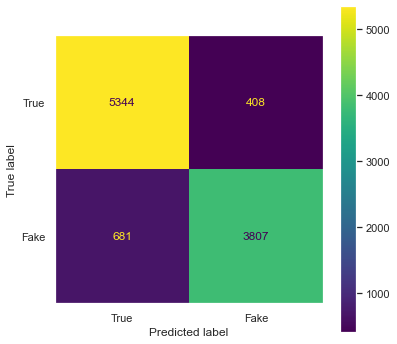

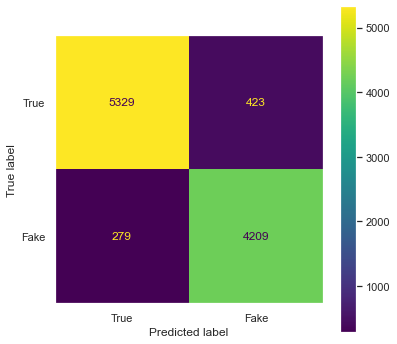

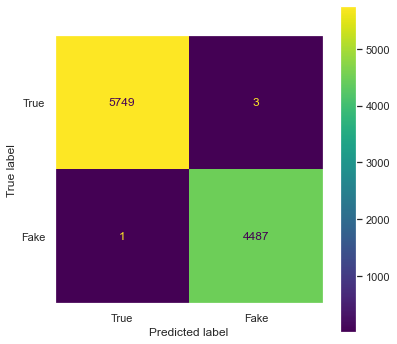

In [50]:
scores1 = cross_validate_models(models1, X_train_clean, y_train_clean, cv=2, cm=True)

In [51]:
scores1

[('MultiNomBa', 0.595703125),
 ('LogisticReg', 0.58271484375),
 ('DecTreeClass', 0.5682617187500001),
 ('RandomFor', 0.60390625),
 ('ExtraTrees', 0.598046875),
 ('GradBoost', 0.58447265625),
 ('SupportVec', 0.60673828125),
 ('StochGrad', 0.5595703125),
 ('PassAgress', 0.548828125),
 ('MultiLayerPerc', 0.5655273437499999)]

Trhe accuracy of the models range from around 54% to around 60%.<br />
We'll now use Tfidf vectorizer for the same models.

In [52]:
mnb_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('mnb', MultinomialNB())])

lr_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('LogisticReg', LogisticRegression())])

dtc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('DecisionTree', DecisionTreeClassifier())])

rf_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('RandomFor', RandomForestClassifier())]) 

etc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('ExtraTrees', ExtraTreesClassifier())]) 

gbc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('gradiendboosting', GradientBoostingClassifier())])

svc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('SupportVec', SVC())])

sgd_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('StochGrad', SGDClassifier())])

pac_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('PassAgress', PassiveAggressiveClassifier())])

mlp_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('MultiLayerPerc', MLPClassifier())])

In [53]:
models2 = [('MultiNomBa', mnb_tfidf),
          ('LogisticReg', lr_tfidf),
          ('DecTreeClass', dtc_tfidf),
          ('RandomFor', rf_tfidf),
          ('ExtraTrees', etc_tfidf),
          ('GradBoost', gbc_tfidf),
          ('SupportVec', svc_tfidf),
          ('StochGrad', sgd_tfidf),
          ('PassAgress', pac_tfidf),
          ('MultiLayerPerc', mlp_tfidf)]

In [54]:
scores2 = cross_validate_models(models2, X_train_clean, y_train_clean, cv=2)

In [55]:
scores2

[('MultiNomBa', 0.5951171875000001),
 ('LogisticReg', 0.6005859375),
 ('DecTreeClass', 0.55810546875),
 ('RandomFor', 0.59990234375),
 ('ExtraTrees', 0.5960937500000001),
 ('GradBoost', 0.5801757812499999),
 ('SupportVec', 0.6017578125),
 ('StochGrad', 0.58095703125),
 ('PassAgress', 0.55),
 ('MultiLayerPerc', 0.5570312500000001)]

Trhe accuracy of the models did not increase by changing only the vectorizer.<br />
Since we have many variables to try in the different models (different hyper parameters, vectorizers, n-gram range), I chose to change adapt my function to evaluate a model at a time, but now we can specify those variables as arguments. This should save me time since I won't go through the pipeline everytime when wanting to evaluate a model.<br />
I'll also be using the validation data to check the models accuracy.

In [246]:
def cross_validate_model(model_name, vectorizer, X, y, cm=False, params=False, params_rs=False, gs_cv=5, ros=False, ngram_range=(1,1)):
    '''
    Input: Model name (str), Vectorizer (str) X, y
    Optional: confusion matric (cm), gridsearch parameters (params), gridsearch cv (gs_cv),
             random over sampling (ros), ngram range (ngram_range)
    Output: model validation accuracy
    If cm=True, print models confusion matrices. Default=False
    If params, performs gridsearch for best parameters
    If params_rs, performs randomized gridsearch for best parameters
    gs_cv specifies the split of X that will be use to gridsearch and to validate. Default=5
    If ros, performs random over sampling
    ngram_range gives the model which ngram range to use with the vectorizer
                default is for unigrams only (1,1), (1,2) considers unigrams and bigrams,
                (2,2) considers just bigrams, (2,3) considers just bigrams and trigrams...
    '''
    # instantiate model
    if model_name == 'mnb':
        model = MultinomialNB()
    elif model_name == 'lr':
        model = LogisticRegression()
    elif model_name == 'dtc':
        model = DecisionTreeClassifier()
    elif model_name == 'rf':
        model = RandomForestClassifier()
    elif model_name == 'etc':
        model = ExtraTreesClassifier()
    elif model_name == 'gbc':
        model = GradientBoostingClassifier()
    elif model_name == 'svc':
        model = SVC()
    elif model_name == 'sgd':
        model = SGDClassifier()
    elif model_name == 'pac':
        model = PassiveAggressiveClassifier()
    elif model_name == 'mlp':
        model = MLPClassifier()
    
    # create pipeline given vectorizer
    if vectorizer == 'cv':
        pipe = Pipeline([('cv', CountVectorizer(ngram_range=ngram_range)),
               (model_name, model)])
    elif vectorizer == 'tfidf':
        pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=ngram_range)),
               (model_name, model)])
    elif vectorizer == 'hash':
        pipe = Pipeline([('hash', HashingVectorizer(ngram_range=ngram_range)),
               (model_name, model)])
    
    # perform random over sampling if ros
    if ros:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(np.array(X).reshape(-1, 1), y)
        X = pd.DataFrame(X).iloc[:,0]
    
    # fit the data
    pipe.fit(X, y) 
    
    # performs gridsearch if params
    if params:
        grid_search = GridSearchCV(pipe, params, cv=gs_cv)
        grid_search.fit(X, y)
        print(model)
        print(grid_search.best_params_)
        
        y_pred = grid_search.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f'Training Accuracy: {round(acc, 4)}')
        y_pred_val = grid_search.predict(X_val_clean)
        acc_val = accuracy_score(y_val_clean, y_pred_val)
        print(f'Validation Accuracy: {round(acc_val, 4)}')
        if cm==True:
            print_cm_with_labels(y, grid_search.predict(X))
    elif params_rs:
        grid_search = RandomizedSearchCV(pipe, params_rs, cv=gs_cv)
        grid_search.fit(X, y)
        print(model)
        print(grid_search.best_params_)
        
        y_pred = grid_search.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f'Training Accuracy: {round(acc, 4)}')
        y_pred_val = grid_search.predict(X_val_clean)
        acc_val = accuracy_score(y_val_clean, y_pred_val)
        print(f'Validation Accuracy: {round(acc_val, 4)}')
        if cm==True:
            print_cm_with_labels(y, grid_search.predict(X))
    else:
        print(model)
        y_pred = pipe.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f'Training Accuracy: {round(acc, 4)}')
        y_pred_val = pipe.predict(X_val_clean)
        acc_val = accuracy_score(y_val_clean, y_pred_val)
        print(f'Validation Accuracy: {round(acc_val, 4)}')        
        if cm==True:
            print_cm_with_labels(y, pipe.predict(X))
    return acc_val

## Baseline Model

The first model I'll use is Logistic Regression. It is a common classification model to classify binary classes, and a goof fit for a baseline model. I'll feed it the raw dataset, in which the texts are not processed. To improve this model, I'll use the preprocessed data, change the vectorizer, add different n-grams, aplly random over sampling and perform hyperparameter tuning. I chose accuracy as a metric to evaluate the model's performance, since both false negatives and false positives can be problematic. I'll also run more complex classification models, tune their hyperparameters, and make use of a neural network. Additionally, I'll use unsupervised machine learning algorithms called Clustering and Latent Dirichlet Allocation.

In [58]:
# Change the train data enough so the model can run
baseline_train_df = raw_train.copy()
baseline_train_df = baseline_train_df.dropna(subset=['statement'], axis=0)
baseline_train_df = label(baseline_train_df)
baseline_X_train = baseline_train_df['statement']
baseline_y_train = baseline_train_df['label']

LogisticRegression()
Training Accuracy: 0.8827
Validation Accuracy: 0.5802


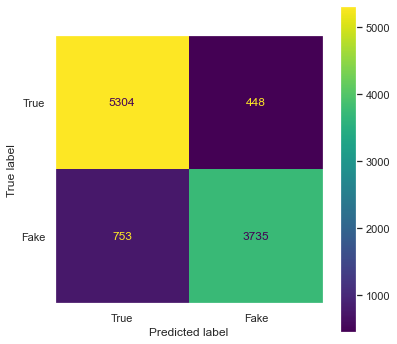

In [60]:
baseline = cross_validate_model('lr', 'cv', baseline_X_train, baseline_y_train, cm=True)

The baseline model has a training accuracy or around 88%, but the cross validation score is around 58%. That probably means that the model is overfit in the training data. Hyperparameter tuning should help to solve that issue in my newer models.

## Classification Models <a class="anchor" id="Classification"></a>

#### Naive Bayes

In [62]:
mnb_params_1 = [{'mnb__alpha':[.001, .01, .05, .1, .2, .4, .6, .8, 1]}]

Mnb_1 = cross_validate_model('mnb', 'cv', X_train_clean, y_train_clean, params=mnb_params_1)

MultinomialNB()
{'mnb__alpha': 1}
Training Accuracy: 0.7873
Validation Accuracy: 0.6036


In [64]:
Mnb_2 = cross_validate_model('mnb', 'tfidf', X_train_clean, y_train_clean, params=mnb_params_1, ros=True, ngram_range=(1,3))

MultinomialNB()
{'mnb__alpha': 1}
Training Accuracy: 0.9876
Validation Accuracy: 0.6121


There seem to be a lot of improvement that can be gained by fine tuning, but the Naive Bayes model seem to overfit a lot.<br /> Next I'll try with different models.

#### Logistic Regression

In [65]:
lr_params_1 = [{
    'lr__C':[0.001, 0.1, 1],
    'lr__solver':['lbfgs', 'saga', 'newton-cg', 'liblinear', 'sag'],
    'lr__fit_intercept':[True, False],
    'lr__penalty':['l1', 'l2', 'elasticnet', None],
    'lr__class_weight': ['balanced',  None],
}]

lr_1 = cross_validate_model('lr', 'cv', X_train_clean, y_train_clean, params=lr_params_1)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.744
Validation Accuracy: 0.6168


In [232]:
lr_params_2 = [{
    'lr__C':[0.1],
    'lr__solver':['saga'],
    'lr__fit_intercept':[False],
    'lr__penalty':['l2'],
    'lr__class_weight': [None],
}]

In [68]:
lr_2 = cross_validate_model('lr', 'tfidf', X_train_clean, y_train_clean, ros=True, params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.6972
Validation Accuracy: 0.6277


In [69]:
lr_3 = cross_validate_model('lr', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.7763
Validation Accuracy: 0.6324


LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.7907
Validation Accuracy: 0.6371


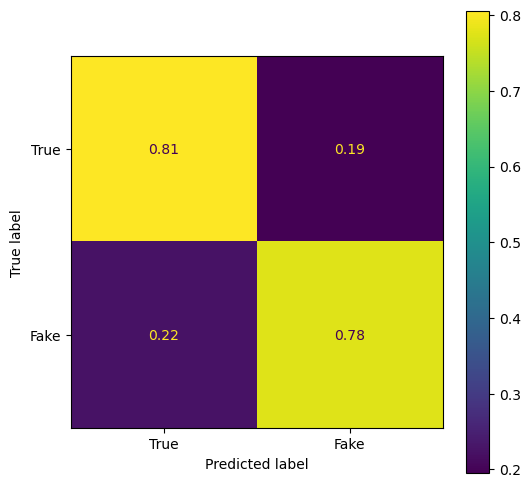

In [247]:
lr_0 = cross_validate_model('lr', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=lr_params_2, cm=True)

In [70]:
lr_4 = cross_validate_model('lr', 'hash', X_train_clean, y_train_clean, ros=True, params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.6681
Validation Accuracy: 0.6231


In [71]:
lr_5 = cross_validate_model('lr', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.6977
Validation Accuracy: 0.6207


In [72]:
lr_6 = cross_validate_model('lr', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,3), params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.7182
Validation Accuracy: 0.6176


For Logistic Regression, the best model uses a tfidf vectorizer with bigram range of (1,2) and ros.

#### Decision Tree Classifier

In [73]:
dtc_params_1 = [{
    'dtc__criterion':['gini', 'entropy'],
    'dtc__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'dtc__ccp_alpha':[.001, .01, .1, .5],
    'dtc__splitter':['random', 'best'],
    'dtc__class_weight': ['balanced',  None]
}]

dtc_1 = cross_validate_model('dtc', 'cv', X_train_clean, y_train_clean, params=dtc_params_1)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0.001, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5933
Validation Accuracy: 0.5732


We can notice a closer proximity between the training and the validation accuracies, suggesting less overfitting of the training data. The number are still very low and need more tuning.

In [74]:
dtc_params_2 = [{
    'dtc__criterion':['entropy'],
    'dtc__max_depth':[16],
    'dtc__ccp_alpha':[0],
    'dtc__splitter':['random'],
    'dtc__class_weight': [None]
}]

In [75]:
dtc_2 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5993
Validation Accuracy: 0.535


In [76]:
dtc_3 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.6099
Validation Accuracy: 0.546


In [77]:
dtc_4 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5947
Validation Accuracy: 0.5553


In [78]:
dtc_5 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(2,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5341
Validation Accuracy: 0.5405


In [79]:
dtc_6 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.6139
Validation Accuracy: 0.5654


In [80]:
dtc_7 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5997
Validation Accuracy: 0.5467


In [81]:
dtc_8 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.6047
Validation Accuracy: 0.5405


In [82]:
dtc_9 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(2,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5425
Validation Accuracy: 0.5421


The decision tree models don't seem to work really well for this.

#### Random Forest Classifier

Gridsearches are not optimal for this amount of models, so I'll start using Randomized search to save time.

In [83]:
rf_params_1 = [{
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'rf__ccp_alpha':[.001, .01, .1, .5],
    'rf__n_estimators':[100, 500, 1000],
    'rf__class_weight': ['balanced',  None],
    'rf__max_features': ['auto',  'sqrt', 'log2']
}]

rf_1 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, params_rs=rf_params_1)

RandomForestClassifier()
{'rf__n_estimators': 500, 'rf__max_features': 'sqrt', 'rf__max_depth': 22, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced', 'rf__ccp_alpha': 0.001}
Training Accuracy: 0.6419
Validation Accuracy: 0.602


In [84]:
rf_params_2 = [{
    'rf__criterion':['entropy'],
    'rf__max_depth':[22],
    'rf__ccp_alpha':[.001],
    'rf__n_estimators':[500],
    'rf__class_weight': ['balanced'],
    'rf__max_features': ['sqrt']
}]

In [85]:
rf_2 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6575
Validation Accuracy: 0.6121


In [86]:
rf_3 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, ros=True, params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6526
Validation Accuracy: 0.6067


In [87]:
rf_4 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6671
Validation Accuracy: 0.6199


In [88]:
rf_5 = cross_validate_model('rf', 'tfidf', X_train_clean, y_train_clean, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.7047
Validation Accuracy: 0.6137


In [89]:
rf_6 = cross_validate_model('rf', 'tfidf', X_train_clean, y_train_clean, ros=True, params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6825
Validation Accuracy: 0.6067


In [90]:
rf_7 = cross_validate_model('rf', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.708
Validation Accuracy: 0.6129


In [91]:
rf_8 = cross_validate_model('rf', 'hash', X_train_clean, y_train_clean, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.646
Validation Accuracy: 0.6137


For Random Forests, the best model uses count vectorizer, bigram range of (1,2) and ros.

#### Extra Trees Classifier

In [94]:
etc_params_1 = [{
    'etc__criterion':['gini', 'entropy'],
    'etc__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'etc__ccp_alpha':[0, .001, .01, .1, .5],
    'etc__n_estimators':[100, 500, 1000],
    'etc__class_weight': ['balanced',  'balanced_subsample', None],
    'etc__max_features': ['auto',  'sqrt', 'log2']
}]

etc_1 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, params_rs=etc_params_1)

ExtraTreesClassifier()
{'etc__n_estimators': 500, 'etc__max_features': 'sqrt', 'etc__max_depth': 16, 'etc__criterion': 'entropy', 'etc__class_weight': 'balanced', 'etc__ccp_alpha': 0}
Training Accuracy: 0.7406
Validation Accuracy: 0.602


In [96]:
etc_params_2 = [{
    'etc__criterion':['entropy'],
    'etc__max_depth':[16],
    'etc__ccp_alpha':[0],
    'etc__n_estimators':[500],
    'etc__class_weight': ['balanced'],
    'etc__max_features': ['sqrt']
}]

In [97]:
etc_2 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, ngram_range=(2,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.713
Validation Accuracy: 0.5522


In [98]:
etc_3 = cross_validate_model('etc', 'tfidf', X_train_clean, y_train_clean, ngram_range=(2,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7426
Validation Accuracy: 0.5654


In [395]:
# etc_4 = cross_validate_model('etc', 'hash', X_train_clean, y_train_clean, ngram_range=(2,2), params=etc_params_2)

In [99]:
etc_5 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7715
Validation Accuracy: 0.6153


In [100]:
etc_6 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7725
Validation Accuracy: 0.6114


In [101]:
etc_7 = cross_validate_model('etc', 'tfidf', X_train_clean, y_train_clean, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7959
Validation Accuracy: 0.6106


In [102]:
etc_8 = cross_validate_model('etc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7887
Validation Accuracy: 0.6083


In [401]:
# etc_9 = cross_validate_model('etc', 'hash', X_train_clean, y_train_clean, ngram_range=(1,2), params=etc_params_2)

In [402]:
# etc_10 = cross_validate_model('etc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=etc_params_2)

For extra trees, the best model uses count vectorizer and unigrams and bigrams.

#### Gradient Boosting Classifier

In [103]:
gbc_params_1 = [{
    'gbc__learning_rate':[0.05, 0.1],
    'gbc__n_estimators':[40, 70]
}]

gbc_1 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_1)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.1, 'gbc__n_estimators': 70}
Training Accuracy: 0.6283
Validation Accuracy: 0.5701


In [104]:
gbc_params_2 = [{
    'gbc__learning_rate':[0.05, 0.1],
    'gbc__n_estimators':[70, 100, 500]
}]

gbc_2 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_2)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.05, 'gbc__n_estimators': 500}
Training Accuracy: 0.6818
Validation Accuracy: 0.5911


In [105]:
gbc_params_3 = [{
    'gbc__learning_rate':[0.005, 0.01],
    'gbc__n_estimators':[500, 1000]
}]

gbc_3 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_3)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.01, 'gbc__n_estimators': 1000}
Training Accuracy: 0.6373
Validation Accuracy: 0.5709


In [106]:
gbc_params_4 = [{
    'gbc__learning_rate':[0.001, 0.01],
    'gbc__n_estimators':[1000, 2000]
}]

gbc_4 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_4)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.01, 'gbc__n_estimators': 2000}
Training Accuracy: 0.6655
Validation Accuracy: 0.5841


In [107]:
gbc_params_5 = [{
    'gbc__learning_rate':[0.02, 0.01],
    'gbc__n_estimators':[3000, 2000]
}]

gbc_5 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_5)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.02, 'gbc__n_estimators': 2000}
Training Accuracy: 0.7136
Validation Accuracy: 0.5997


In [108]:
gbc_params_6 = [{
    'gbc__learning_rate':[0.02],
    'gbc__n_estimators':[2000],
    'gbc__loss':['deviance', 'exponential'],
    'gbc__max_features': ['sqrt',  'log2', None]
}]

gbc_6 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_6)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.02, 'gbc__loss': 'deviance', 'gbc__max_features': None, 'gbc__n_estimators': 2000}
Training Accuracy: 0.713
Validation Accuracy: 0.6036


In [110]:
# gbc_params_7 = [{
#     'gbc__criterion':['mae', 'friedman_mse'],
#     'gbc__loss':['deviance'],
#     'gbc__learning_rate':[0.02],
#     'gbc__n_estimators':[2000]
# }]
# gbc_7 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_7)

In [112]:
# gbc_params_8 = [{
#     'gbc__loss':['deviance'],
#     'gbc__learning_rate':[0.02],
#     'gbc__n_estimators':[2000],
#     'gbc__max_features': [None],
#     'gbc__subsample': [1, 0.8],
#     'gbc__max_depth': [3, 5, 7, 12],
#     'gbc__min_samples_leaf': [1, 5, 15, 25],
# }]
# gbc_8 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_8)

In [ ]:
# gbc_7 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_7)

Gradient Boosting isn't increasing our validation accuracy

#### C-Support Vector Classification

In [113]:
svc_params_1 = [{
    'svc__C':[0.5, 1, 1.5],
    'svc__shrinking':[True, False]
}]

svc_1 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, params_rs=svc_params_1)

SVC()
{'svc__shrinking': True, 'svc__C': 1}
Training Accuracy: 0.91
Validation Accuracy: 0.6254


In [114]:
svc_params_2 = [{
    'svc__C':[1],
    'svc__gamma':['scale', 'auto'],
    'svc__tol':[0.001, 0.0001],
    'svc__shrinking':[True]
}]

svc_2 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, params_rs=svc_params_2)

SVC()
{'svc__tol': 0.001, 'svc__shrinking': True, 'svc__gamma': 'scale', 'svc__C': 1}
Training Accuracy: 0.91
Validation Accuracy: 0.6254


In [115]:
svc_params_3 = [{
    'svc__C':[1],
    'svc__gamma':['scale'],
    'svc__tol':[0.01, 0.001],
    'svc__shrinking':[True],
    'svc__class_weight': ['balanced', None]
}]

svc_3 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, params_rs=svc_params_3)

SVC()
{'svc__tol': 0.001, 'svc__shrinking': True, 'svc__gamma': 'scale', 'svc__class_weight': None, 'svc__C': 1}
Training Accuracy: 0.91
Validation Accuracy: 0.6254


In [116]:
svc_params_4 = [{
    'svc__C':[1],
    'svc__gamma':['scale'],
    'svc__tol':[0.001,],
    'svc__shrinking':[True],
    'svc__class_weight': [None]
}]

In [117]:
svc_4 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, ros=True, params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9292
Validation Accuracy: 0.6168


In [118]:
svc_5 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9625
Validation Accuracy: 0.6246


In [119]:
svc_6 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9895
Validation Accuracy: 0.5958


In [120]:
svc_7 = cross_validate_model('svc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9988
Validation Accuracy: 0.5919


In [121]:
svc_8 = cross_validate_model('svc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9987
Validation Accuracy: 0.5888


In [122]:
svc_9 = cross_validate_model('svc', 'hash', X_train_clean, y_train_clean, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.995
Validation Accuracy: 0.574


In [123]:
svc_10 = cross_validate_model('svc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9969
Validation Accuracy: 0.5771


The best svc model uses count vectorizer, unigrams and has a validation accuracy of around 62.54%.

#### Stochastic Gradient Descent Classifier

In [124]:
sgd_params_1 = [{
    'sgd__loss':['hinge', 'log'],
    'sgd__alpha':[0.01, 0.001, 0.0001],
    'sgd__early_stopping': [True]
}]

sgd_1 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_1)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__loss': 'hinge'}
Training Accuracy: 0.6495
Validation Accuracy: 0.6121


In [125]:
sgd_params_2 = [{
    'sgd__loss':['log'],
    'sgd__penalty':['l1', 'l2'],
    'sgd__alpha':[0.1, 0.01],
    'sgd__early_stopping': [True]
}]

sgd_2 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_2)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6617
Validation Accuracy: 0.6207


In [126]:
sgd_params_3 = [{
    'sgd__loss':['log'],
    'sgd__penalty':['l2'],
    'sgd__alpha':[0.01],
    'sgd__fit_intercept':[True, False],
    'sgd__learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'],
    'sgd__early_stopping': [True]
}]

sgd_3 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_3)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6616
Validation Accuracy: 0.6238


In [127]:
sgd_params_4 = [{
    'sgd__loss':['log'],
    'sgd__penalty':['l2'],
    'sgd__alpha':[0.01],
    'sgd__fit_intercept':[False],
    'sgd__learning_rate': ['optimal'],
    'sgd__early_stopping': [True]
}]

sgd_4 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.662
Validation Accuracy: 0.6285


In [128]:
sgd_5 = cross_validate_model('sgd', 'tfidf', X_train_clean, y_train_clean, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6274
Validation Accuracy: 0.5724


In [129]:
sgd_6 = cross_validate_model('sgd', 'hash', X_train_clean, y_train_clean, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6213
Validation Accuracy: 0.5896


In [130]:
sgd_7 = cross_validate_model('sgd', 'tfidf', X_train_clean, y_train_clean, ros=True, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6627
Validation Accuracy: 0.6254


In [131]:
sgd_8 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, ros=True, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6633
Validation Accuracy: 0.6207


In [132]:
sgd_9 = cross_validate_model('sgd', 'tfidf', X_train_clean, y_train_clean, ngram_range=(1,2), params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.672
Validation Accuracy: 0.5818


In [133]:
sgd_10 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, ngram_range=(1,2), params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.7182
Validation Accuracy: 0.6269


The best validation accuracy for SGD classifier is 62.85%, and is from a model with cv as vectorizer and uses unigrams only.

#### Passive Aggressive Classifier

In [134]:
pac_params_1 = [{
    'pac__C':[0.5, 1.0, 1.5, 2.0],
    'pac__fit_intercept':[True,False]
}]

pac_1 = cross_validate_model('pac', 'cv', X_train_clean, y_train_clean, params=pac_params_1)

PassiveAggressiveClassifier()
{'pac__C': 1.5, 'pac__fit_intercept': True}
Training Accuracy: 0.9261
Validation Accuracy: 0.56


In [135]:
pac_params_2 = [{
    'pac__C':[1.5],
    'pac__fit_intercept':[True],
    'pac__class_weight': ['balanced', None],
    'pac__average': [True, False, 5, 10]
}]

pac_2 = cross_validate_model('pac', 'cv', X_train_clean, y_train_clean, params=pac_params_2)

PassiveAggressiveClassifier()
{'pac__C': 1.5, 'pac__average': 10, 'pac__class_weight': None, 'pac__fit_intercept': True}
Training Accuracy: 0.9536
Validation Accuracy: 0.5561


It doesn't seem like the valdiation accuracy will improve for these models, so I'll stop the tuning here.

#### Multi-layer Perceptron Classifier

In [135]:
# mlp_params_1 = [{
#     'mlp__activation':['identity', 'logistic', 'tanh', 'relu']
# }]

# mlp_1 = cross_validate_model('mlp', 'cv', X_train_clean, y_train_clean, params=mlp_params_1)


KeyboardInterrupt



In [ ]:
# mlp_params_2 = [{
#     'mlp__activation':['identity', 'logistic', 'tanh', 'relu'],
#     'mlp__alpha':[0.01, 0.001, 0.0001],
#     'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],

# }]

The Multi-Layer Perceptron models were taking too long to run and were interupted because of  time constrainsts.

## Neural Networks <a class="anchor" id="Neural_Network"></a>

The work regarding all the Neural Networks tried is in the [Neural Network Notebook](Liar-Plus-NeuralNetworks.ipynb). The best model can be found below.

In [261]:
#
#
#
#

## Clustering <a class="anchor" id="Clustering"></a>

The work regarding Clustering can be found in the [Clustering Notebook](Liar-Plus-Clustering.ipynb).

In [264]:
#
#
#


## Latent Dirichlet Analisys <a class="anchor" id="lda"></a>

The topic exploration of this work is within the [LDA Notebook](Liar-Plus-LDA.ipynb).

In [265]:
#
#
#

# III. Final Model <a class="anchor" id="Final_Model"></a>

The model with the highest accuracy is the ...

In [266]:
# Show library with accuracies
# Show confusion matrix of best model
# Show model performance graph
#

# IV. Results <a class="anchor" id="Results"></a>

Now it's time to run our final model against the test set:

In [ ]:
# Create model again
# Give test accuracy
# Print test Confusion Matrix

# V. Reccommendations <a class="anchor" id="Reccommendations"></a>

In [267]:
#
#
#

## Next Steps <a class="anchor" id="Next_Steps"></a>

For further development, I propose:
   * Create models for different languages
      - Different languages have different semantic structures. If this model is to be reproduced for a different language, we'd need fo find pre-trained embeddings in that language to use in our vocabulary
   * Use the Metadata
       - The person making the statement, their political affiliation,  other characteristics may affect how the model operates. If we have that information for new statements, it could give us a more accurate classification

# Contact <a class="anchor" id="Contact"></a>

For any further questions, feel free to reach me:

#### Marcelo Scatena
marcelo.oddo@gmail.com<br />
[Github](https://github.com/moscatena)<br />
[LinkedIn](https://www.linkedin.com/in/marcelo-scatena/)

##### References:<br />
Reimche, Roman. (2018). Comparison of the diffusion of real and fake news in social networks.. 10.13140/RG.2.2.35221.22243. <br />
[“Liar, Liar Pants on Fire”: A New Benchmark Dataset for Fake News Detection](https://aclanthology.org/P17-2067) (Wang, ACL 2017)<br />
[Where is Your Evidence: Improving Fact-checking by Justification Modeling](https://aclanthology.org/W18-5513) (Alhindi et al., 2018)<br />


In [220]:
skyler_graph = {'Baseline': 58.02, 'Bayes        \ntfidf-ngram(1,3)': 61.21, 'Logistic Regression\ntfidf-ngram(1,2)  ': 63.24,
               'Decision Tree    \nhash-ngram(1,1)': 56.54, 'Random Forest\ncv-ngram(1,2)': 61.99, 'Extra Trees    \ncv-ngram(1,2)': 61.53,
               'Gradient Boost\ncv-ngram(1,1)': 60.36, 'SVC        \ncv-ngram(1,1)': 62.54, 'SGD         \ncv-ngram(1,1)': 62.85}

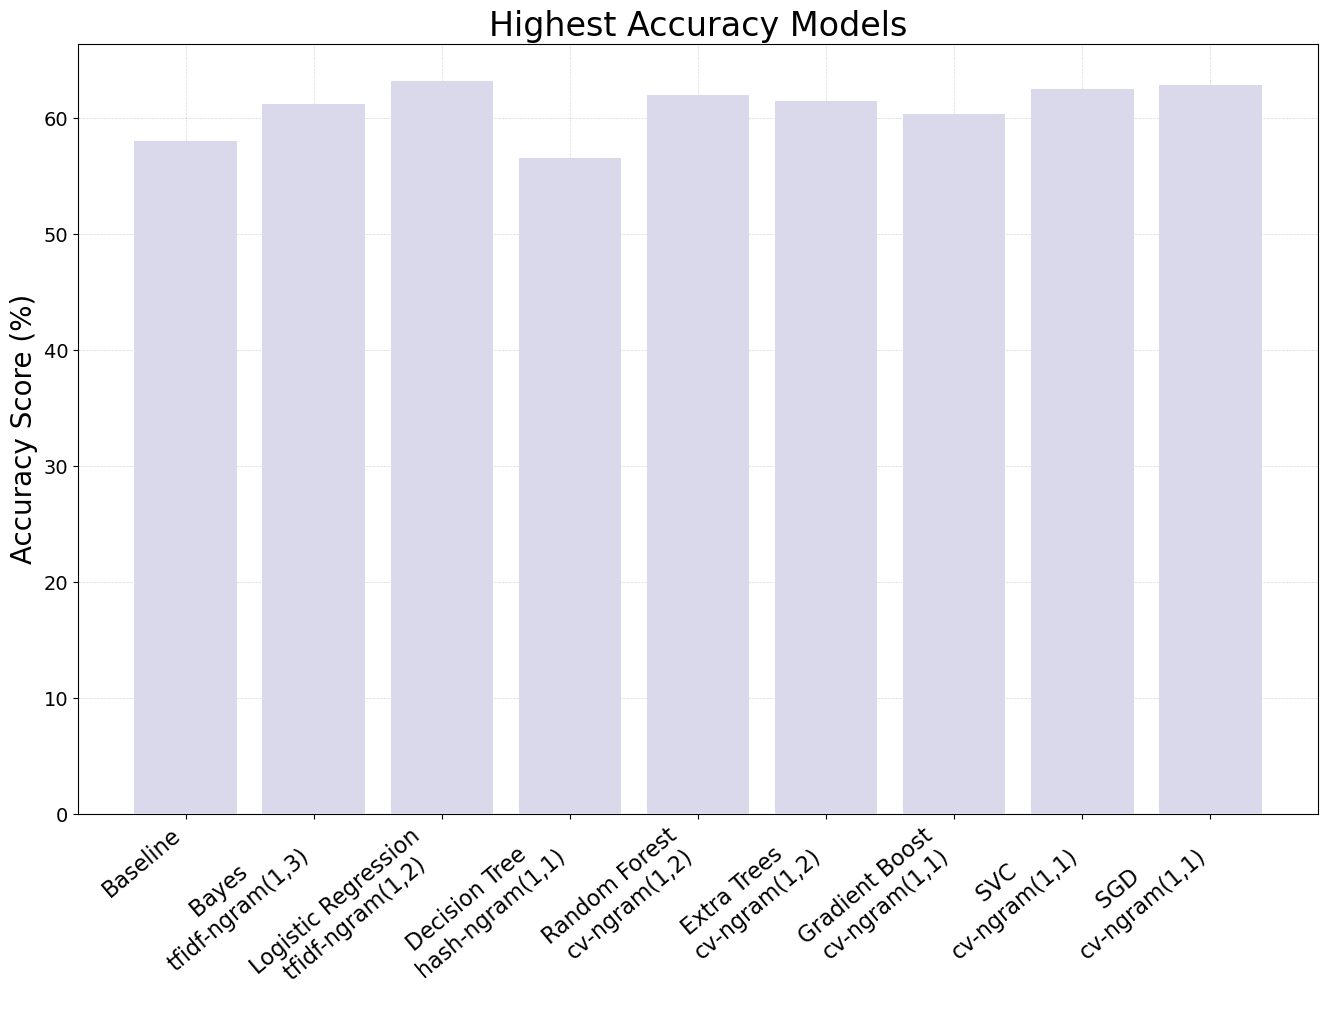

<Figure size 640x480 with 0 Axes>

In [224]:
# Visualize the chages from baseline to tuned models
plt.style.use('default')

fig, ax = plt.subplots(figsize=(16, 10))

c = ['#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb', 
     '#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb']

model_names = [model_name for model_name, value in skyler_graph.items()]
model_scores = [value for model_name, value in skyler_graph.items()]

plt.bar(model_names, model_scores, color=c, zorder=3)

ax.set_title('Highest Accuracy Models', fontsize=24)
plt.xticks(rotation=40, ha='right', fontsize=16)
plt.yticks(fontsize=14)
ax.set_ylabel('Accuracy Score (%)', fontsize=20)

plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)
plt.show()
# plt.savefig('./images/skyler_graph_01')

## Best Accuracies

In [256]:
skyler_graph2 = {'Keras Tokenizer': 52.85,  'Keras Tokenizer \n with LSTM layer': 57.17, 'Keras Tokenizer with  \n      LSTM layer & Dropout': 58.48,
                'Keras Tokenizer with \n      LSTM layer, Dropout\n & Regularization     ': 59.03, 'Google nnlm-en': 62.85}

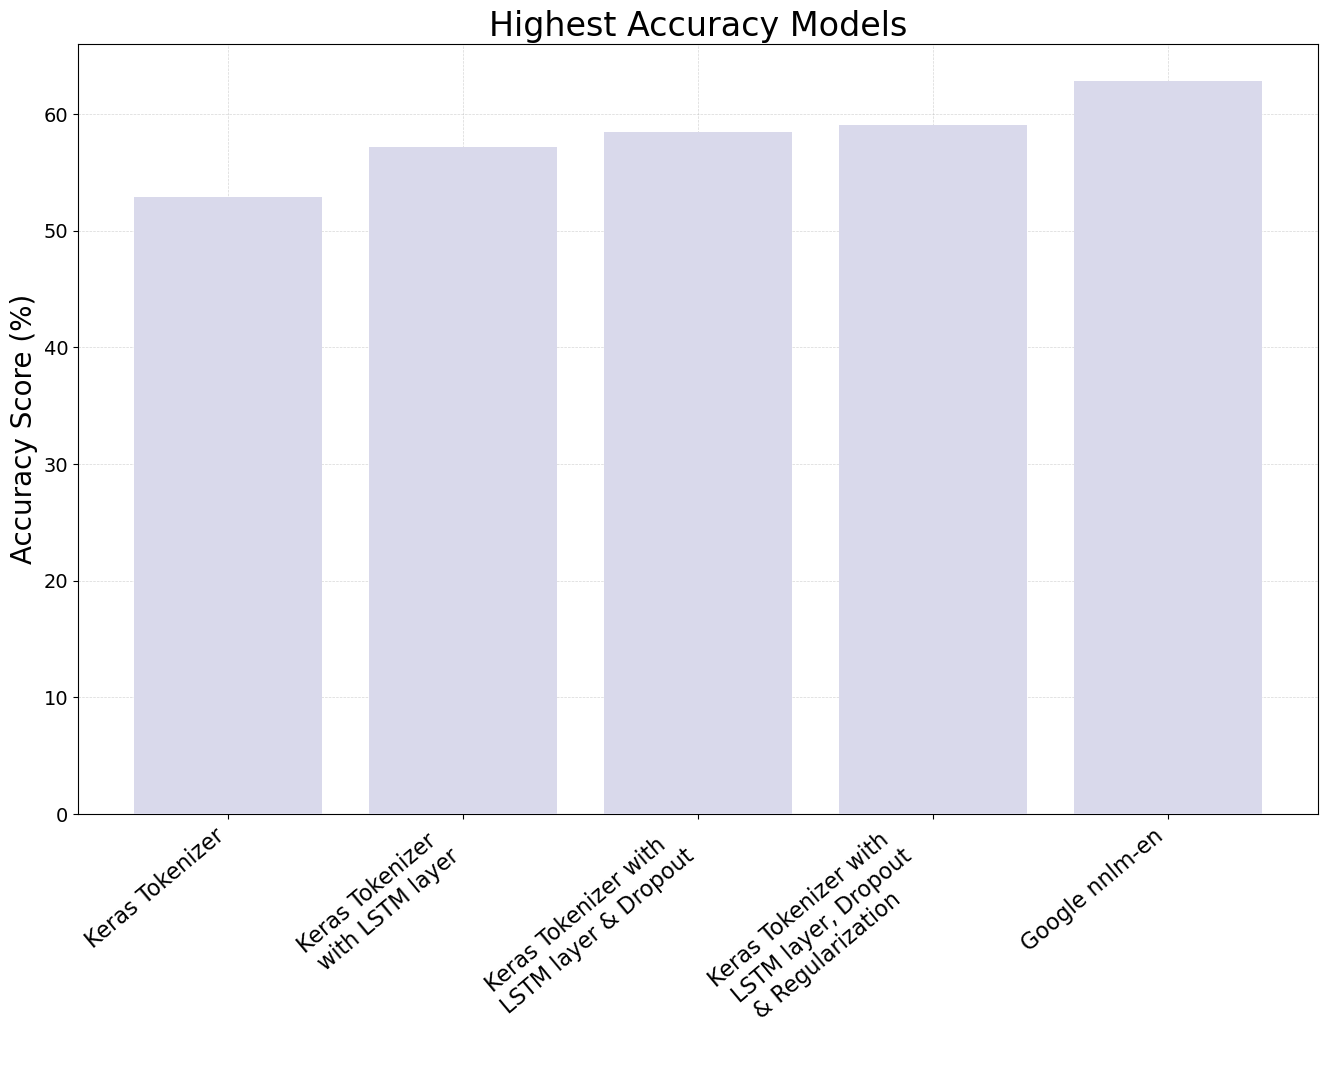

In [257]:
# Visualize the chages from baseline to tuned models
plt.style.use('default')

fig, ax = plt.subplots(figsize=(16, 10))

c = ['#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb']

model_names_nn = [model_name for model_name, value in skyler_graph2.items()]
model_scores_nn = [value for model_name, value in skyler_graph2.items()]

plt.bar(model_names_nn, model_scores_nn, color=c, zorder=3)

ax.set_title('Highest Accuracy Models', fontsize=24)
plt.xticks(rotation=40, ha='right', fontsize=16)
plt.yticks(fontsize=14)
ax.set_ylabel('Accuracy Score (%)', fontsize=20)

plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)
plt.show()
# plt.savefig('./images/skyler_graph_01')